<a href="https://www.kaggle.com/code/mh0386/facial-emotions-detection?scriptVersionId=156859835" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.applications.xception import Xception
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.svm import SVC
from sklearn_genetic import GASearchCV
from sklearn_genetic.plots import plot_search_space
from sklearn_genetic.space import Continuous, Categorical, Integer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load images and labels
path_local = "../facial_emotion_dataset/"
path_kaggle = "/kaggle/input/facial-emotion/"

general_path = path_local if os.path.exists(path_local) else path_kaggle
path_train_images = os.path.join(general_path, "train")  # Path to training images
path_test_images = os.path.join(general_path, "test")  # Path to test images

In [4]:
def limit_data(data_dir):
    a = []
    for i in os.listdir(data_dir):
        for k, j in enumerate(os.listdir(data_dir + "/" + i)):
            a.append((f"{data_dir}/{i}/{j}", i))
    return pd.DataFrame(a, columns=["filename", "class"])

In [5]:
# Use the function to limit the data
limited_train_data = limit_data(path_train_images)
limited_test_data = limit_data(path_test_images)

In [6]:
# Data augmentation
datagen = ImageDataGenerator(rescale=1.0 / 255)
train_dataset = datagen.flow_from_dataframe(dataframe=limited_train_data)
test_dataset = datagen.flow_from_dataframe(dataframe=limited_test_data)

Found 112 validated image filenames belonging to 8 classes.
Found 40 validated image filenames belonging to 8 classes.


In [7]:
train_dataset.image_shape

(256, 256, 3)

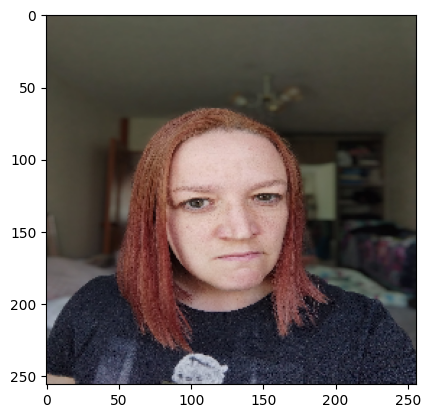

In [8]:
plt.imshow(train_dataset.next()[0][0])

# Now we will try to use exception Feature extraction architecture 

In [9]:
non_trainable_model = Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(
        train_dataset.image_shape[0],
        train_dataset.image_shape[1],
        train_dataset.image_shape[2],
    ),
)

83683744/83683744 [==============================] - 0s 0us/step


In [10]:
for layer in non_trainable_model.layers:
    layer.trainable = False

In [11]:
x = non_trainable_model.output
x = tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
flatten = tf.keras.layers.Flatten()(x)
predictions = tf.keras.layers.Dense(8, activation="softmax")(flatten)

In [12]:
# x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [13]:
model = tf.keras.Model(inputs=non_trainable_model.input, outputs=predictions)

In [14]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
model.fit(train_dataset, epochs=30)

Epoch 1/30
4/4 [==============================] - 15s 955ms/step - loss: 8.8386 - accuracy: 0.0982
Epoch 2/30
4/4 [==============================] - 8s 2s/step - loss: 3.4248 - accuracy: 0.1964
Epoch 3/30
4/4 [==============================] - 8s 2s/step - loss: 2.1040 - accuracy: 0.2946
Epoch 4/30
4/4 [==============================] - 7s 2s/step - loss: 1.7412 - accuracy: 0.3661
Epoch 5/30
4/4 [==============================] - 7s 2s/step - loss: 1.6515 - accuracy: 0.4107
Epoch 6/30
4/4 [==============================] - 8s 2s/step - loss: 1.4368 - accuracy: 0.5536
Epoch 7/30
4/4 [==============================] - 8s 2s/step - loss: 1.2126 - accuracy: 0.6875
Epoch 8/30
4/4 [==============================] - 8s 2s/step - loss: 0.9907 - accuracy: 0.7946
Epoch 9/30
4/4 [==============================] - 8s 2s/step - loss: 0.8205 - accuracy: 0.8750
Epoch 10/30
4/4 [==============================] - 8s 2s/step - loss: 0.6300 - accuracy: 0.9464
Epoch 11/30
4/4 [============================

In [16]:
model2 = tf.keras.Model(inputs=non_trainable_model.input, outputs=flatten)

In [18]:
train_data_flatten = model2.predict(train_dataset)
test_data_flatten = model2.predict(test_dataset)

2/2 [==============================] - 3s 913ms/step


In [19]:
y_train = np.array(train_dataset.classes)
y_test = np.array(test_dataset.classes)

In [20]:
train_dataset.next()[0].shape, y_train.shape, train_data_flatten.shape

((32, 256, 256, 3), (112,), (112, 900))

In [21]:
y_train

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4])

In [22]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7])

# SVM

In [23]:
svm_model = SVC(kernel="poly", C=1, gamma="auto")

In [24]:
svm_model.fit(train_data_flatten, y_train)

SVC(C=1, gamma='auto', kernel='poly')

In [25]:
accuracy_svm = svm_model.score(test_data_flatten, y_test)
print("Accuracy:", accuracy_svm)

Accuracy: 0.175


In [26]:
# Define the search space for hyperparameters
search_space_svm = {
    "C": Continuous(0.1, 10),
    "gamma": Categorical(["scale", "auto"]),
    "kernel": Categorical(["linear", "poly", "rbf", "sigmoid"]),
    "degree": Integer(1, 6),
    "coef0": Continuous(0, 1),
    "shrinking": Categorical([True, False]),
    "probability": Categorical([True, False]),
    "tol": Continuous(1e-5, 1e-2),
}

In [27]:
# Use the genetic algorithm to search for the best hyperparameters
genetic_algo_svm = GASearchCV(
    estimator=svm_model,
    param_grid=search_space_svm,
    scoring="accuracy",
    cv=2,
    verbose=True,
    generations=40,
    n_jobs=-1,
)

In [28]:
train_data_flatten.shape, y_train.shape

((112, 900), (112,))

In [29]:
genetic_algo_svm.fit(train_data_flatten, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.126607	0.0187874  	0.151786   	0.0982143  
1  	100   	0.144464	0.00887304 	0.151786   	0.125      
2  	100   	0.15    	0.00399298 	0.151786   	0.133929   
3  	100   	0.15125 	0.00212042 	0.151786   	0.142857   
4  	100   	0.151786	0          	0.151786   	0.151786   
5  	100   	0.151786	0          	0.151786   	0.151786   
6  	100   	0.151786	0          	0.151786   	0.151786   
7  	100   	0.151786	0          	0.151786   	0.151786   
8  	100   	0.151786	0          	0.151786   	0.151786   
9  	100   	0.151786	0          	0.151786   	0.151786   
10 	100   	0.151786	0          	0.151786   	0.151786   
11 	100   	0.151786	0          	0.151786   	0.151786   
12 	100   	0.151786	0          	0.151786   	0.151786   
13 	100   	0.151786	0          	0.151786   	0.151786   
14 	100   	0.151786	0          	0.151786   	0.151786   
15 	100   	0.151786	0          	0.151786   	0.151786   
16 	100   	0.151786	0          	0.151786   	0.15

GASearchCV(cv=2,
           estimator=SVC(C=8.881232378806326, coef0=0.4875785380497193,
                         degree=5, gamma='auto', shrinking=False,
                         tol=0.006826027421497119),
           generations=40, n_jobs=-1,
           param_grid={'C': <sklearn_genetic.space.space.Continuous object at 0x7f9815f17820>,
                       'coef0': <sklearn_genetic.space.space.Continuous object at 0x7f98204236a0>,
                       'degree': <sklearn_genetic.space.spac...
                       'gamma': <sklearn_genetic.space.space.Categorical object at 0x7f9815f178e0>,
                       'kernel': <sklearn_genetic.space.space.Categorical object at 0x7f9815f17850>,
                       'probability': <sklearn_genetic.space.space.Categorical object at 0x7f982cbf80d0>,
                       'shrinking': <sklearn_genetic.space.space.Categorical object at 0x7f982cd89510>,
                       'tol': <sklearn_genetic.space.space.Continuous object at 0x7f9815f0fa00>},
           return_train_score=True, scoring='accuracy')

In [30]:
best_model_svm = genetic_algo_svm.best_estimator_
best_params_svm = genetic_algo_svm.best_params_

In [31]:
best_params_svm

{'C': 8.881232378806326,
 'gamma': 'auto',
 'kernel': 'rbf',
 'degree': 5,
 'coef0': 0.4875785380497193,
 'shrinking': False,
 'probability': False,
 'tol': 0.006826027421497119}

In [32]:
accuracy_svm = best_model_svm.score(test_data_flatten, y_test)
print("Accuracy:", accuracy_svm)

Accuracy: 0.15


# XGBoost

In [33]:
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train)),
    max_depth=10,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1e-5,
    gamma=0.1,
    random_state=42,
)

In [34]:
xgb_model.fit(train_data_flatten, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=8,
              num_parallel_tree=None, ...)

In [35]:
accuracy_xgb = xgb_model.score(test_data_flatten, y_test)
print("Accuracy:", accuracy_xgb)

Accuracy: 0.175


In [36]:
# Define the search space for hyperparameters
search_space_xgb = {
    "max_depth": Integer(1, 10),
    "learning_rate": Continuous(0.01, 1),
    "n_estimators": Integer(10, 100),
    "subsample": Continuous(0.1, 1),
    "colsample_bytree": Continuous(0.1, 1),
    "reg_alpha": Continuous(1e-5, 1e-2),
    "gamma": Continuous(0, 1),
}

In [37]:
# Use the genetic algorithm to search for the best hyperparameters
genetic_algo_xgb = GASearchCV(
    estimator=xgb_model,
    param_grid=search_space_xgb,
    scoring="accuracy",
    cv=10,
    verbose=True,
    generations=40,
    n_jobs=-1,
)

In [38]:
genetic_algo_xgb.fit(train_data_flatten, y_train)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	50    	0.14553	0.0248172  	0.203788   	0.0954545  
1  	100   	0.166167	0.0249814  	0.205303   	0.105303   
2  	100   	0.179621	0.0192247  	0.220455   	0.134848   
3  	100   	0.188848	0.0137395  	0.213636   	0.159091   
4  	100   	0.190576	0.0145495  	0.212879   	0.141667   
5  	100   	0.192258	0.0156481  	0.212879   	0.159091   
6  	100   	0.193455	0.0157326  	0.212879   	0.159091   
7  	100   	0.197788	0.0125079  	0.212879   	0.159091   
8  	100   	0.201697	0.0162069  	0.248485   	0.15       
9  	100   	0.207152	0.0175602  	0.248485   	0.159091   
10 	100   	0.204515	0.0198195  	0.248485   	0.140909   
11 	100   	0.213636	0.0172608  	0.248485   	0.168182   
12 	100   	0.218015	0.0211092  	0.248485   	0.159091   
13 	100   	0.228212	0.0195552  	0.248485   	0.177273   
14 	100   	0.228439	0.0230508  	0.248485   	0.159091   
15 	100   	0.232273	0.021047   	0.265909   	0.149242   
16 	100   	0.236636	0.0209736  	0.267424   	0.1507

GASearchCV(cv=10,
           estimator=XGBClassifier(base_score=None, booster=None,
                                   callbacks=None, colsample_bylevel=None,
                                   colsample_bynode=None,
                                   colsample_bytree=0.3295245206840729,
                                   device=None, early_stopping_rounds=None,
                                   enable_categorical=False, eval_metric=None,
                                   feature_types=None, gamma=0.8576542759026835,
                                   grow_policy=None, importance_type=None,
                                   interaction_constrain...
                       'learning_rate': <sklearn_genetic.space.space.Continuous object at 0x7f98dfcb22f0>,
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x7f98dfcb3f10>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x7f98dfcb00d0>,
                       'reg_alpha': <sklearn_genetic.space.space.Continuous object at 0x7f98dfcb1240>,
                       'subsample': <sklearn_genetic.space.space.Continuous object at 0x7f98dfcb0370>},
           return_train_score=True, scoring='accuracy')

In [39]:
best_model_xgb = genetic_algo_xgb.best_estimator_
best_params_xgb = genetic_algo_xgb.best_params_

In [40]:
best_params_xgb

{'max_depth': 10,
 'learning_rate': 0.619057131413639,
 'n_estimators': 87,
 'subsample': 0.11967468228106634,
 'colsample_bytree': 0.3295245206840729,
 'reg_alpha': 0.0006133493782099056,
 'gamma': 0.8576542759026835}

In [41]:
accuracy_xgb = best_model_xgb.score(test_data_flatten, y_test)
print("Accuracy:", accuracy_xgb)

Accuracy: 0.05


In [42]:
class AntColonyOptimization:
    def __init__(self, num_ants, max_iter=10, Model=XGBClassifier()):
        self.model = Model
        self.best_selected_features = None
        self.best_fitness = None
        self.final_report = None
        self.final_f1 = None
        self.final_recall = None
        self.final_precision = None
        self.final_accuracy = None
        self.final_confusion_mat = None
        self.num_ants = num_ants
        self.max_iter = max_iter

    @staticmethod
    def _initialize_pheromones(num_features):
        return np.ones(num_features)

    def _select_features(self, pheromones):
        probabilities = pheromones / np.sum(pheromones)
        selected_features = np.random.choice(
            len(pheromones), size=self.num_ants, p=probabilities
        )
        return selected_features

    def _fitness(self, selected_features, X_train, Y_train, X_test, Y_test):
        if len(selected_features) == 0:
            return 0  # Penalize if no features are selected
        self.model.fit(X_train[:, selected_features], Y_train)
        y_predict = self.model.predict(X_test[:, selected_features])
        Accuracy = accuracy_score(Y_test, y_predict)
        precision = precision_score(Y_test, y_predict, average="weighted")
        recall = recall_score(Y_test, y_predict, average="weighted")
        f1 = f1_score(Y_test, y_predict, average="weighted")
        report = classification_report(Y_test, y_predict)
        confusion_mat = confusion_matrix(Y_test, y_predict)
        return Accuracy, precision, recall, f1, report, confusion_mat

    def run(self, X_train, Y_train, X_test, Y_test):
        num_features = X_train.shape[1]
        pheromones = self._initialize_pheromones(num_features)
        self.best_fitness = 0

        for iteration in range(self.max_iter):
            # Initialize ant colony
            selected_features = self._select_features(pheromones)

            # Evaluate fitness
            fitness_value = self._fitness(
                selected_features, X_train, Y_train, X_test, Y_test
            )

            # Update pheromones based on fitness values
            pheromones[selected_features] += fitness_value[
                0
            ]  # Update based on accuracy (you can choose other metrics)

            print(f"Iteration: {iteration + 1},\tBest Fitness: {self.best_fitness:.4f}")

            # Update the best solution if a better one is found
            if (
                    fitness_value[0] > self.best_fitness
            ):  # Update based on accuracy (you can choose other metrics)
                self.best_fitness = fitness_value[0]
                self.best_selected_features = selected_features

        # print("Best Selected Features:", self.best_selected_features)
        print("\nBest Fitness (Accuracy):", self.best_fitness)

        # Use the best-selected features for prediction on the test set

        self.model.fit(X_train[:, self.best_selected_features], Y_train)
        y_predict = self.model.predict(X_test[:, self.best_selected_features])

        # Calculate metrics for the final model
        self.final_accuracy = accuracy_score(Y_test, y_predict)
        self.final_precision = precision_score(Y_test, y_predict, average="weighted")
        self.final_recall = recall_score(Y_test, y_predict, average="weighted")
        self.final_f1 = f1_score(Y_test, y_predict, average="weighted")
        self.final_report = classification_report(Y_test, y_predict)
        self.final_confusion_mat = confusion_matrix(Y_test, y_predict)

        return self.best_selected_features

    def results(self):
        # Plot the confusion matrix using Seaborn
        print("The Confusion Matrix is: ")
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            self.final_confusion_mat,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test),
        )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # Print the classification report
        print("The Classification Report is: ")
        print(self.final_report)

        # Print the accuracy, precision, recall, and f1_score
        print(f"Accuracy: {self.final_accuracy: .4f}")
        print(f"Best Fitness: {self.best_fitness: .4f}")
        print(f"Precision: {self.final_precision: .4f}")
        print(f"Recall: {self.final_recall: .4f}")
        print(f"F1-Score: {self.final_f1: .4f}")

In [43]:
aco_optimizer_xgb = AntColonyOptimization(num_ants=500, max_iter=1500, Model=xgb_model)
selected_features_aco = aco_optimizer_xgb.run(
    train_data_flatten, y_train, test_data_flatten, y_test
)

Iteration: 1,	Best Fitness: 0.0000
Iteration: 2,	Best Fitness: 0.2000
Iteration: 3,	Best Fitness: 0.2000
Iteration: 4,	Best Fitness: 0.3000
Iteration: 5,	Best Fitness: 0.3000
Iteration: 6,	Best Fitness: 0.3000
Iteration: 7,	Best Fitness: 0.3000
Iteration: 8,	Best Fitness: 0.3000
Iteration: 9,	Best Fitness: 0.3000
Iteration: 10,	Best Fitness: 0.3000
Iteration: 11,	Best Fitness: 0.3000
Iteration: 12,	Best Fitness: 0.3000
Iteration: 13,	Best Fitness: 0.3000
Iteration: 14,	Best Fitness: 0.3000
Iteration: 15,	Best Fitness: 0.3000
Iteration: 16,	Best Fitness: 0.3000
Iteration: 17,	Best Fitness: 0.3000
Iteration: 18,	Best Fitness: 0.3000
Iteration: 19,	Best Fitness: 0.3000
Iteration: 20,	Best Fitness: 0.3000
Iteration: 21,	Best Fitness: 0.3000
Iteration: 22,	Best Fitness: 0.3000
Iteration: 23,	Best Fitness: 0.3000
Iteration: 24,	Best Fitness: 0.3000
Iteration: 25,	Best Fitness: 0.3000
Iteration: 26,	Best Fitness: 0.3000
Iteration: 27,	Best Fitness: 0.3000
Iteration: 28,	Best Fitness: 0.3000
I

The Confusion Matrix is: 


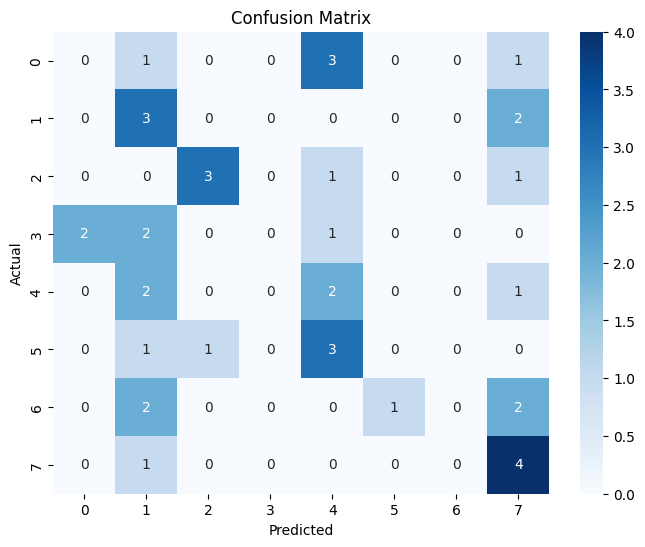

The Classification Report is: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.25      0.60      0.35         5
           2       0.75      0.60      0.67         5
           3       0.00      0.00      0.00         5
           4       0.20      0.40      0.27         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.36      0.80      0.50         5

    accuracy                           0.30        40
   macro avg       0.20      0.30      0.22        40
weighted avg       0.20      0.30      0.22        40

Accuracy:  0.3000
Best Fitness:  0.3000
Precision:  0.1955
Recall:  0.3000
F1-Score:  0.2233


In [44]:
aco_optimizer_xgb.results()

In [45]:
aco_optimizer_svm = AntColonyOptimization(num_ants=500, max_iter=1500, Model=svm_model)
selected_features_aco = aco_optimizer_svm.run(
    train_data_flatten, y_train, test_data_flatten, y_test
)

Iteration: 1,	Best Fitness: 0.0000
Iteration: 2,	Best Fitness: 0.1750
Iteration: 3,	Best Fitness: 0.1750
Iteration: 4,	Best Fitness: 0.1750
Iteration: 5,	Best Fitness: 0.1750
Iteration: 6,	Best Fitness: 0.2000
Iteration: 7,	Best Fitness: 0.2000
Iteration: 8,	Best Fitness: 0.2000
Iteration: 9,	Best Fitness: 0.2250
Iteration: 10,	Best Fitness: 0.2250
Iteration: 11,	Best Fitness: 0.2250
Iteration: 12,	Best Fitness: 0.2250
Iteration: 13,	Best Fitness: 0.2250
Iteration: 14,	Best Fitness: 0.2250
Iteration: 15,	Best Fitness: 0.2250
Iteration: 16,	Best Fitness: 0.2250
Iteration: 17,	Best Fitness: 0.2250
Iteration: 18,	Best Fitness: 0.2250
Iteration: 19,	Best Fitness: 0.2250
Iteration: 20,	Best Fitness: 0.2250
Iteration: 21,	Best Fitness: 0.2250
Iteration: 22,	Best Fitness: 0.2250
Iteration: 23,	Best Fitness: 0.2250
Iteration: 24,	Best Fitness: 0.2250
Iteration: 25,	Best Fitness: 0.2250
Iteration: 26,	Best Fitness: 0.2250
Iteration: 27,	Best Fitness: 0.2250
Iteration: 28,	Best Fitness: 0.2250
I

The Confusion Matrix is: 


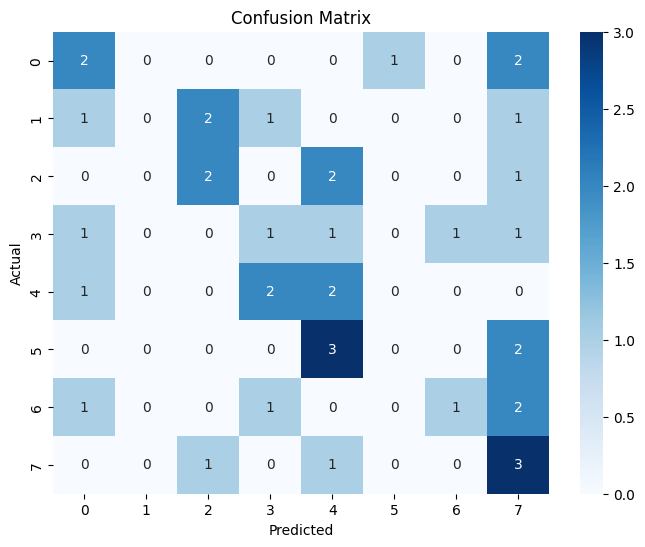

The Classification Report is: 
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.00      0.00      0.00         5
           2       0.40      0.40      0.40         5
           3       0.20      0.20      0.20         5
           4       0.22      0.40      0.29         5
           5       0.00      0.00      0.00         5
           6       0.50      0.20      0.29         5
           7       0.25      0.60      0.35         5

    accuracy                           0.28        40
   macro avg       0.24      0.28      0.24        40
weighted avg       0.24      0.28      0.24        40

Accuracy:  0.2750
Best Fitness:  0.2750
Precision:  0.2382
Recall:  0.2750
F1-Score:  0.2360


In [46]:
aco_optimizer_svm.results()